# Generic Time Series Modeling for Volatility Forecasting

This notebook applies classical time series forecasting methods to predict realized volatility for individual stocks (AAPL, NVDA) and an equal-weighted MAG7 portfolio. We compare three fundamental approaches to establish baseline performance for volatility prediction.

## Analysis Structure

1. **Data Loading & Preparation** - Load 21-day annualized realized volatility for stocks and portfolio
2. **Train-Test Split** - Split data into 80% training and 20% testing sets
3. **Stationarity Testing** - Verify series stationarity using Augmented Dickey-Fuller test
4. **ARIMA Modeling** - Grid search over autoregressive integrated moving average configurations
5. **Exponential Smoothing** - Test SES, Holt, and Holt-Winters methods
6. **Prophet Modeling** - Apply Facebook's Prophet with trend and seasonality components
7. **Model Comparison** - Evaluate all models using MAE, RMSE, MAPE, and R² metrics
8. **Summary** - Key findings and recommendations

## Objective

Identify the most effective classical time series method for volatility forecasting at both individual stock and portfolio levels, establishing a baseline for comparison with more advanced machine learning and deep learning techniques.

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', message='A date index has been provided')

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Preparation

In [102]:
# Load volatility data
vol_df = pd.read_csv('data/processed/volatility_21d_annualized.csv', parse_dates=['Date'], index_col='Date')

# Load portfolio data
portfolio_df = pd.read_csv('data/processed/portfolio_equal_weight.csv', parse_dates=['Date'], index_col='Date')

# Select AAPL, NVDA, and Portfolio
stocks = ['AAPL', 'NVDA', 'Portfolio']
vol_data = vol_df[['AAPL', 'NVDA']].copy()
vol_data['Portfolio'] = portfolio_df['Portfolio_RV_21d']
vol_data = vol_data.dropna()

print(f"Data shape: {vol_data.shape}")
print(f"Date range: {vol_data.index.min()} to {vol_data.index.max()}")
print(f"\nSummary Statistics:")
print(vol_data.describe())

Data shape: (2725, 3)
Date range: 2015-02-03 00:00:00 to 2025-12-02 00:00:00

Summary Statistics:
              AAPL         NVDA    Portfolio
count  2725.000000  2725.000000  2725.000000
mean      0.261711     0.447450     0.256544
std       0.124571     0.191599     0.126309
min       0.077741     0.139772     0.067448
25%       0.184124     0.310013     0.167602
50%       0.236195     0.390086     0.226078
75%       0.306450     0.552495     0.318261
max       1.068829     1.393049     1.002035


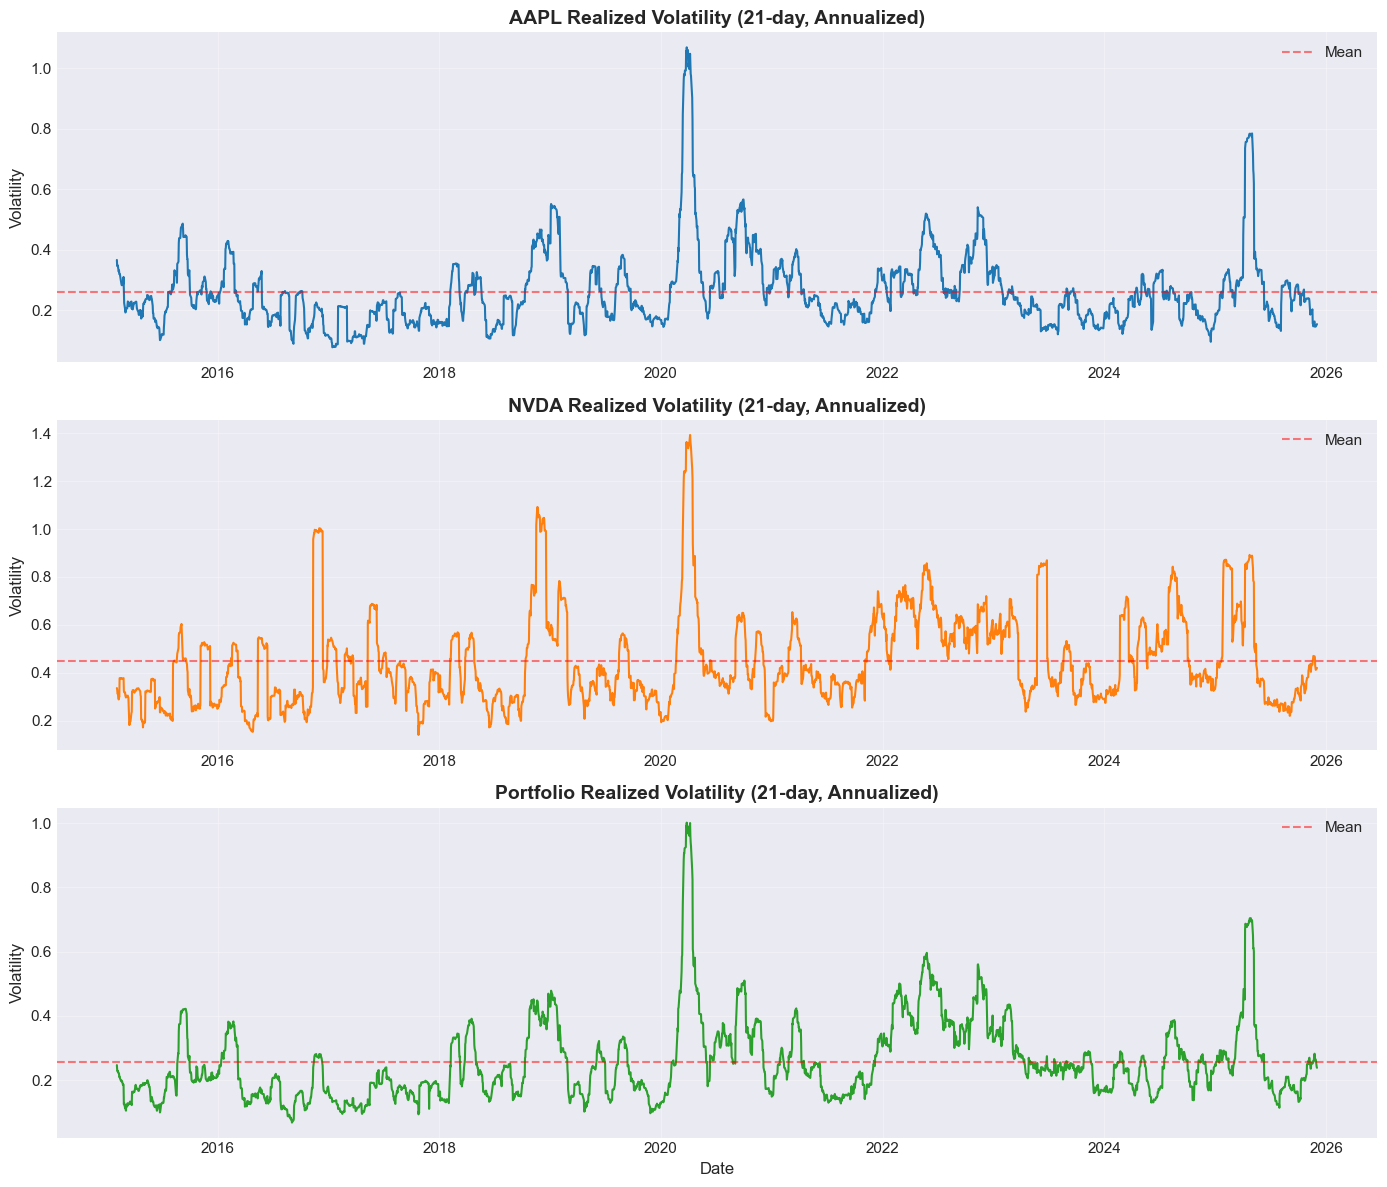

In [103]:
# Visualize the volatility series
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

colors_stocks = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, stock in enumerate(stocks):
    axes[i].plot(vol_data.index, vol_data[stock], linewidth=1.5, color=colors_stocks[i])
    axes[i].set_title(f'{stock} Realized Volatility (21-day, Annualized)', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility', fontsize=12)
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=vol_data[stock].mean(), color='red', linestyle='--', alpha=0.5, label='Mean')
    axes[i].legend()

axes[2].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

## 2. Train-Test Split

We'll use an 80-20 split for training and testing.

In [104]:
# Split data into train and test sets
train_size = int(len(vol_data) * 0.8)
train_data = vol_data.iloc[:train_size]
test_data = vol_data.iloc[train_size:]

print(f"Training set: {train_data.index[0]} to {train_data.index[-1]} ({len(train_data)} samples)")
print(f"Test set: {test_data.index[0]} to {test_data.index[-1]} ({len(test_data)} samples)")

Training set: 2015-02-03 00:00:00 to 2023-09-29 00:00:00 (2180 samples)
Test set: 2023-10-02 00:00:00 to 2025-12-02 00:00:00 (545 samples)


## 3. Stationarity Testing

Use Augmented Dickey-Fuller test to check if series are stationary (required assumption for ARIMA modeling).

In [105]:
def adf_test(series, name):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna())
    is_stationary = result[1] < 0.05
    status = "✓ Stationary" if is_stationary else "✗ Non-stationary"
    print(f"{name}: {status} (p-value: {result[1]:.4f})")
    return is_stationary

# Test stationarity for all stocks including portfolio
print("Stationarity Test Results:")
for stock in stocks:
    adf_test(train_data[stock], stock)

Stationarity Test Results:
AAPL: ✓ Stationary (p-value: 0.0000)
NVDA: ✓ Stationary (p-value: 0.0001)
Portfolio: ✓ Stationary (p-value: 0.0011)


## 4. ARIMA Modeling

**Model Overview:**
ARIMA (AutoRegressive Integrated Moving Average) models time series as a combination of:
- **AR(p)**: Autoregressive component - uses past values to predict future (like momentum)
- **I(d)**: Integration - differences the series d times to achieve stationarity
- **MA(q)**: Moving Average - uses past forecast errors to improve predictions

ARIMA is effective for capturing linear dependencies and trends but assumes stationarity (constant mean/variance over time).

### 4.1 Model Selection via Grid Search

We test 108 ARIMA(p,d,q) configurations where p,d,q ∈ {0-5, 0-2, 0-5} respectively. Selection uses **AIC (Akaike Information Criterion)**, which balances model fit against complexity - lower AIC indicates better trade-off between accuracy and simplicity. We also report **BIC (Bayesian Information Criterion)**, which penalizes complexity more heavily than AIC.

In [106]:
def find_best_arima(series, p_range=range(0, 6), d_range=range(0, 3), q_range=range(0, 6)):
    """Grid search for best ARIMA parameters based on AIC"""
    best_aic = np.inf
    best_params = None
    best_model = None
    
    results = []
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(series, order=(p, d, q))
                    fitted = model.fit()
                    results.append({
                        'order': (p, d, q),
                        'aic': fitted.aic,
                        'bic': fitted.bic,
                        'hqic': fitted.hqic
                    })
                    
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_params = (p, d, q)
                        best_model = fitted
                except:
                    continue
    
    results_df = pd.DataFrame(results).sort_values('aic').head(10)
    return best_model, best_params, results_df

# Find best ARIMA models for all stocks including portfolio
print("Starting ARIMA model selection...")
arima_models = {}
arima_params = {}
arima_results = {}

for stock in stocks:
    print(f"{stock}: Searching {6*3*6} ARIMA configurations...", end=" ")
    
    model, params, results_df = find_best_arima(train_data[stock].dropna())
    arima_models[stock] = model
    arima_params[stock] = params
    arima_results[stock] = results_df
    
    print(f"\nBest: ARIMA{params} (AIC: {model.aic:.2f}, BIC: {model.bic:.2f})\n")

Starting ARIMA model selection...
AAPL: Searching 108 ARIMA configurations... 
Best: ARIMA(2, 0, 5) (AIC: -11054.23, BIC: -11003.05)

NVDA: Searching 108 ARIMA configurations... 
Best: ARIMA(5, 0, 5) (AIC: -7894.34, BIC: -7826.09)

Portfolio: Searching 108 ARIMA configurations... 
Best: ARIMA(3, 0, 2) (AIC: -11596.56, BIC: -11556.75)



### 4.2 ARIMA Forecasting

In [107]:
# Generate forecasts
arima_forecasts = {}
arima_conf_int = {}

for stock in stocks:
    # Forecast
    forecast_result = arima_models[stock].forecast(steps=len(test_data), alpha=0.05)
    arima_forecasts[stock] = forecast_result
    
    # Get prediction intervals
    pred = arima_models[stock].get_prediction(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)
    arima_conf_int[stock] = pred.conf_int(alpha=0.05)

print("ARIMA forecasts generated successfully!")

ARIMA forecasts generated successfully!


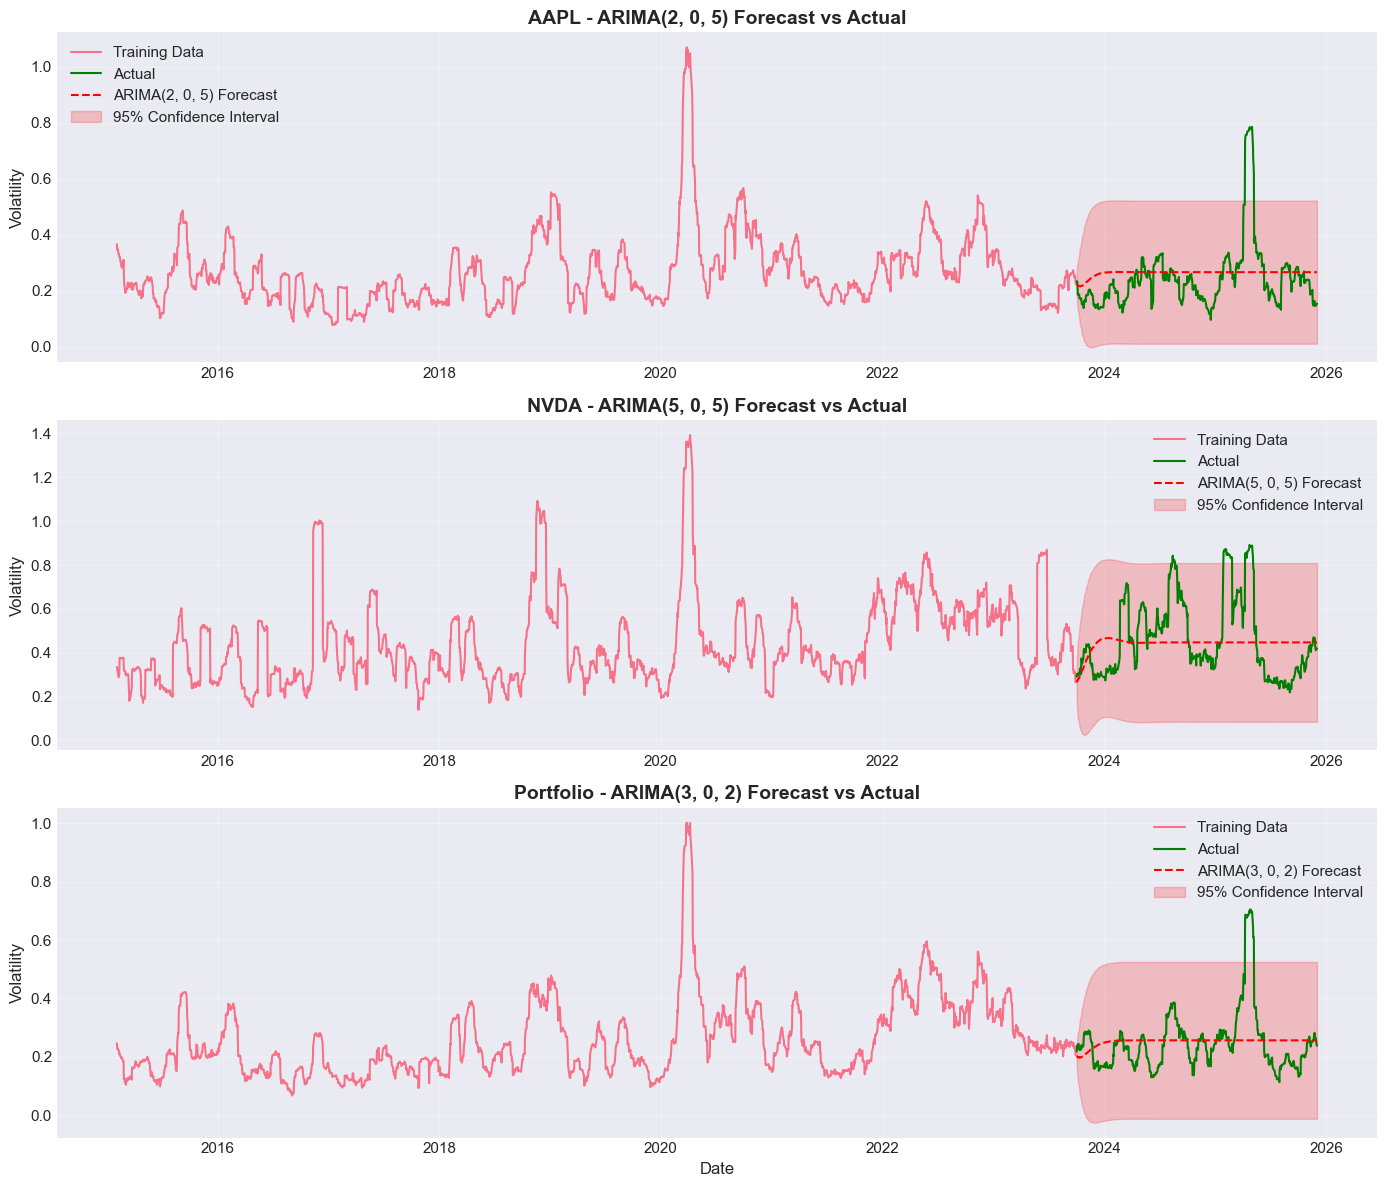

In [108]:
# Plot ARIMA forecasts
fig, axes = plt.subplots(len(stocks), 1, figsize=(14, 12))
if len(stocks) == 1:
    axes = [axes]

for i, stock in enumerate(stocks):
    # Plot training data
    axes[i].plot(train_data.index, train_data[stock], label='Training Data', linewidth=1.5)
    
    # Plot test data
    axes[i].plot(test_data.index, test_data[stock], label='Actual', linewidth=1.5, color='green')
    
    # Plot forecast
    axes[i].plot(test_data.index, arima_forecasts[stock], label=f'ARIMA{arima_params[stock]} Forecast', 
                linewidth=1.5, color='red', linestyle='--')
    
    # Plot confidence interval
    axes[i].fill_between(test_data.index, 
                         arima_conf_int[stock].iloc[:, 0], 
                         arima_conf_int[stock].iloc[:, 1],
                         alpha=0.2, color='red', label='95% Confidence Interval')
    
    axes[i].set_title(f'{stock} - ARIMA{arima_params[stock]} Forecast vs Actual', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility', fontsize=12)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

In [109]:
# Calculate ARIMA performance metrics
def calculate_metrics(actual, predicted, model_name):
    """Calculate and display performance metrics"""
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"MAE:  {mae:.6f}")
    print(f"MSE:  {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²:   {r2:.4f}")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

arima_metrics = {}
for stock in stocks:
    arima_metrics[stock] = calculate_metrics(test_data[stock], arima_forecasts[stock], 
                                             f"{stock} - ARIMA{arima_params[stock]}")


AAPL - ARIMA(2, 0, 5) Performance Metrics:
MAE:  0.075083
MSE:  0.014042
RMSE: 0.118499
MAPE: nan%
R²:   0.0009

NVDA - ARIMA(5, 0, 5) Performance Metrics:
MAE:  0.144811
MSE:  0.032577
RMSE: 0.180491
MAPE: nan%
R²:   -0.0057

Portfolio - ARIMA(3, 0, 2) Performance Metrics:
MAE:  0.071917
MSE:  0.011677
RMSE: 0.108058
MAPE: nan%
R²:   -0.0040


## 5. Exponential Smoothing

**Model Overview:**
Exponential Smoothing methods forecast by weighting recent observations more heavily than older ones. The weight decays exponentially into the past, making these models responsive to recent changes. We test four variants:
- **SES (Simple)**: Level only, no trend or seasonality
- **Holt**: Adds linear trend component
- **Holt-Winters Additive**: Includes seasonal component added to trend
- **Holt-Winters Multiplicative**: Seasonal component multiplied with trend (better for varying seasonal amplitude)

These models are particularly effective for data with clear trend and seasonal patterns.

### 5.1 Model Selection

We fit all four exponential smoothing variants and select the best using **AIC**, which measures model quality while penalizing excess parameters. Lower AIC indicates better balance between fit and model complexity. We use 21-day seasonal periods to capture monthly volatility cycles.

In [110]:
def fit_exponential_smoothing_models(series, name):
    """Fit multiple exponential smoothing models and compare"""
    models = {}
    aic_scores = {}
    
    # Simple Exponential Smoothing
    try:
        model_ses = ExponentialSmoothing(series, trend=None, seasonal=None)
        fit_ses = model_ses.fit(optimized=True)
        models['SES'] = fit_ses
        aic_scores['SES'] = fit_ses.aic
    except Exception as e:
        print(f"SES failed: {e}")
    
    # Holt's Linear Trend
    try:
        model_holt = ExponentialSmoothing(series, trend='add', seasonal=None)
        fit_holt = model_holt.fit(optimized=True)
        models['Holt'] = fit_holt
        aic_scores['Holt'] = fit_holt.aic
    except Exception as e:
        print(f"Holt failed: {e}")
    
    # Holt-Winters Additive (need sufficient data for seasonal)
    try:
        model_hw_add = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=21)
        fit_hw_add = model_hw_add.fit(optimized=True)
        models['HW_Additive'] = fit_hw_add
        aic_scores['HW_Additive'] = fit_hw_add.aic
    except Exception as e:
        print(f"HW Additive failed: {e}")
    
    # Holt-Winters Multiplicative
    try:
        model_hw_mul = ExponentialSmoothing(series, trend='add', seasonal='mul', seasonal_periods=21)
        fit_hw_mul = model_hw_mul.fit(optimized=True)
        models['HW_Multiplicative'] = fit_hw_mul
        aic_scores['HW_Multiplicative'] = fit_hw_mul.aic
    except Exception as e:
        print(f"HW Multiplicative failed: {e}")
    
    # Find best model
    best_model_name = min(aic_scores, key=aic_scores.get)
    best_model = models[best_model_name]
    
    print(f"{name} - Exponential Smoothing Model Comparison:")
    for model_name, aic in sorted(aic_scores.items(), key=lambda x: x[1]):
        print(f"{model_name:20s}: AIC = {aic:.4f}")
    print(f"Best model: {best_model_name}\n")
    
    return models, best_model_name, best_model

# Fit models for all stocks including portfolio
es_models = {}
es_best_names = {}
es_best_models = {}

for stock in stocks:
    print(f"Fitting Exponential Smoothing models for {stock}...")
    models, best_name, best_model = fit_exponential_smoothing_models(train_data[stock].dropna(), stock)
    es_models[stock] = models
    es_best_names[stock] = best_name
    es_best_models[stock] = best_model

Fitting Exponential Smoothing models for AAPL...
AAPL - Exponential Smoothing Model Comparison:
SES                 : AIC = -17149.5368
Holt                : AIC = -17126.2146
HW_Multiplicative   : AIC = -17088.0249
HW_Additive         : AIC = -17086.0081
Best model: SES

Fitting Exponential Smoothing models for NVDA...
NVDA - Exponential Smoothing Model Comparison:
SES                 : AIC = -13992.0072
Holt                : AIC = -13988.0086
HW_Multiplicative   : AIC = -13950.2348
HW_Additive         : AIC = -13946.7534
Best model: SES

Fitting Exponential Smoothing models for Portfolio...
Portfolio - Exponential Smoothing Model Comparison:
SES                 : AIC = -17666.3493
Holt                : AIC = -17662.3912
HW_Multiplicative   : AIC = -17624.7700
HW_Additive         : AIC = -17623.3070
Best model: SES



In [111]:
# Display model summaries
for stock in stocks:
    print(f"\n{stock} - {es_best_names[stock]} Model Summary:")
    print(es_best_models[stock].summary())


AAPL - SES Model Summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     AAPL   No. Observations:                 2180
Model:             ExponentialSmoothing   SSE                              0.834
Optimized:                         True   AIC                         -17149.537
Trend:                             None   BIC                         -17138.163
Seasonal:                          None   AICC                        -17149.518
Seasonal Periods:                  None   Date:                 Fri, 05 Dec 2025
Box-Cox:                          False   Time:                         16:45:01
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial

### 5.2 Exponential Smoothing Forecasting

In [112]:
# Generate forecasts
es_forecasts = {}

for stock in stocks:
    es_forecasts[stock] = es_best_models[stock].forecast(steps=len(test_data))

print("Exponential Smoothing forecasts generated successfully!")

Exponential Smoothing forecasts generated successfully!


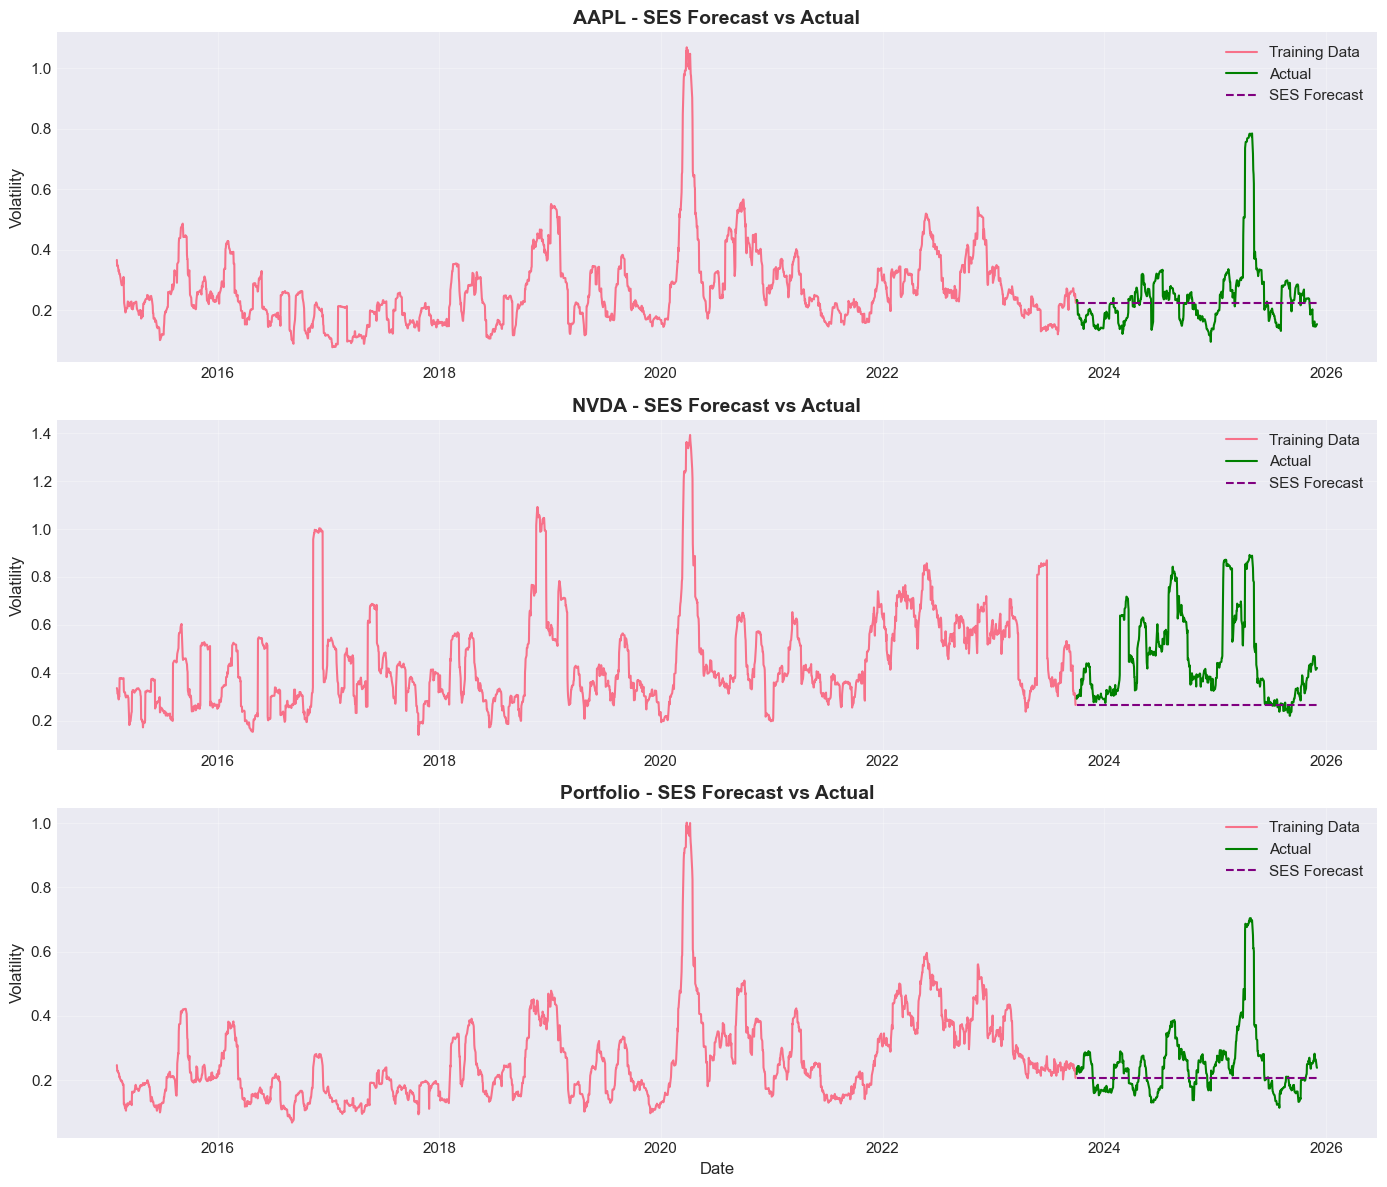

In [113]:
# Plot forecasts
fig, axes = plt.subplots(len(stocks), 1, figsize=(14, 12))
if len(stocks) == 1:
    axes = [axes]

for i, stock in enumerate(stocks):
    # Plot training data
    axes[i].plot(train_data.index, train_data[stock], label='Training Data', linewidth=1.5)
    
    # Plot test data
    axes[i].plot(test_data.index, test_data[stock], label='Actual', linewidth=1.5, color='green')
    
    # Plot forecast
    axes[i].plot(test_data.index, es_forecasts[stock], label=f'{es_best_names[stock]} Forecast', 
                linewidth=1.5, color='purple', linestyle='--')
    
    axes[i].set_title(f'{stock} - {es_best_names[stock]} Forecast vs Actual', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility', fontsize=12)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

In [114]:
# Calculate performance metrics
es_metrics = {}
for stock in stocks:
    es_metrics[stock] = calculate_metrics(test_data[stock], es_forecasts[stock], 
                                          f"{stock} - {es_best_names[stock]}")


AAPL - SES Performance Metrics:
MAE:  0.069372
MSE:  0.014498
RMSE: 0.120408
MAPE: nan%
R²:   -0.0315

NVDA - SES Performance Metrics:
MAE:  0.203239
MSE:  0.072946
RMSE: 0.270085
MAPE: nan%
R²:   -1.2519

Portfolio - SES Performance Metrics:
MAE:  0.071608
MSE:  0.013467
RMSE: 0.116046
MAPE: nan%
R²:   -0.1579


## 6. Prophet Modeling

**Model Overview:**
Prophet is Facebook's time series forecasting library designed for business applications with strong seasonal patterns. It decomposes series into:
- **Trend**: Long-term increase/decrease with automatic changepoint detection
- **Seasonality**: Multiple periodic patterns (yearly, monthly, quarterly) using Fourier series
- **Holidays/Events**: Special date effects (not used here)

Prophet is robust to missing data and outliers, handles multiple seasonalities naturally, and provides interpretable components.

### 6.1 Data Preparation

Prophet requires specific format: 'ds' (datestamp) column for dates and 'y' column for values. We configure multiplicative seasonality (seasonal magnitude scales with trend level) and add custom monthly (30.5 days) and quarterly (91.25 days) components to capture volatility cycles beyond standard yearly patterns.

In [115]:
# Prepare data for Prophet
def prepare_prophet_data(data, stock):
    """Convert data to Prophet format"""
    df = pd.DataFrame({
        'ds': data.index,
        'y': data[stock].values
    })
    return df

# Create Prophet datasets
prophet_train = {}
prophet_test = {}

for stock in stocks:
    prophet_train[stock] = prepare_prophet_data(train_data, stock)
    prophet_test[stock] = prepare_prophet_data(test_data, stock)

print("Prophet data prepared successfully!")
print(f"\nExample format for {stocks[0]}:")
print(prophet_train[stocks[0]].head())

Prophet data prepared successfully!

Example format for AAPL:
          ds         y
0 2015-02-03  0.366262
1 2015-02-04  0.346773
2 2015-02-05  0.346216
3 2015-02-06  0.348397
4 2015-02-09  0.327524


### 6.2 Model Fitting

Fit Prophet with multiplicative seasonality, custom monthly and quarterly components.

In [116]:
# Fit Prophet models
prophet_models = {}

for stock in stocks:
    print(f"\nFitting Prophet model for {stock}...")
    
    # Initialize Prophet with custom parameters
    model = Prophet(
        changepoint_prior_scale=0.05,  # Flexibility of trend
        seasonality_prior_scale=10.0,   # Flexibility of seasonality
        seasonality_mode='multiplicative',  # Multiplicative seasonality
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        interval_width=0.95
    )
    
    # Add custom seasonalities
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=5)
    
    # Fit model
    model.fit(prophet_train[stock])
    prophet_models[stock] = model
    
    print(f"✓ Prophet model fitted for {stock}")

16:45:01 - cmdstanpy - INFO - Chain [1] start processing



Fitting Prophet model for AAPL...


16:45:01 - cmdstanpy - INFO - Chain [1] done processing
16:45:01 - cmdstanpy - INFO - Chain [1] start processing


✓ Prophet model fitted for AAPL

Fitting Prophet model for NVDA...


16:45:01 - cmdstanpy - INFO - Chain [1] done processing
16:45:01 - cmdstanpy - INFO - Chain [1] start processing


✓ Prophet model fitted for NVDA

Fitting Prophet model for Portfolio...


16:45:02 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet model fitted for Portfolio


### 6.3 Prophet Visualization


AAPL - Prophet Forecast


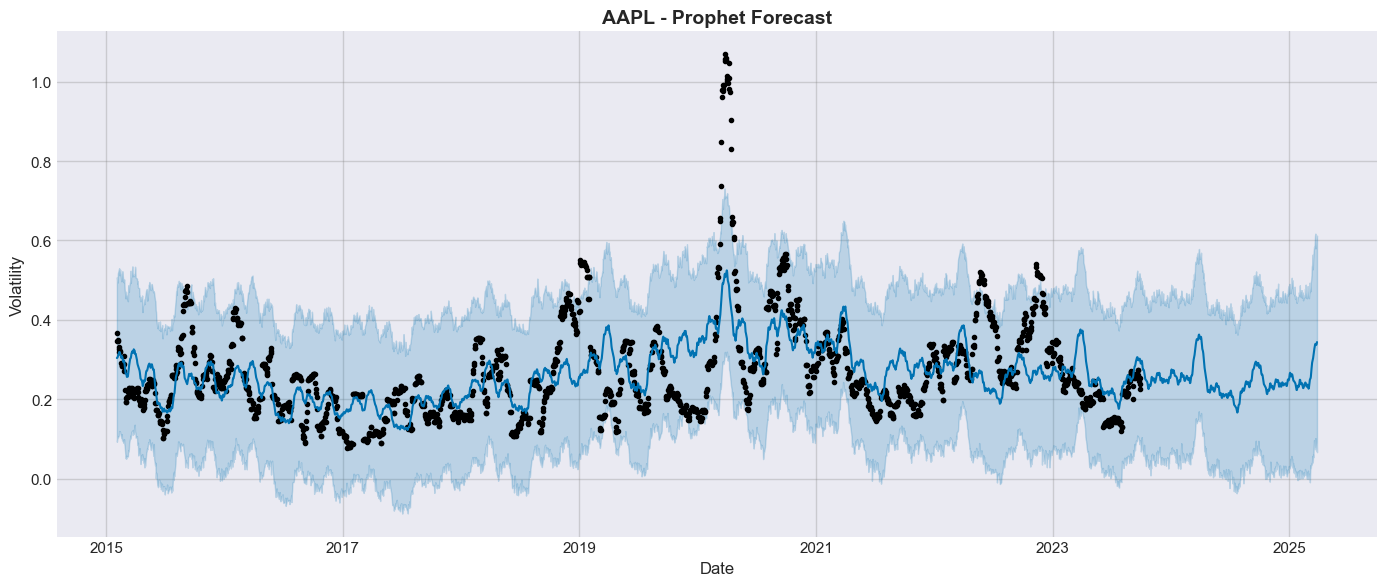


AAPL - Prophet Forecast Components


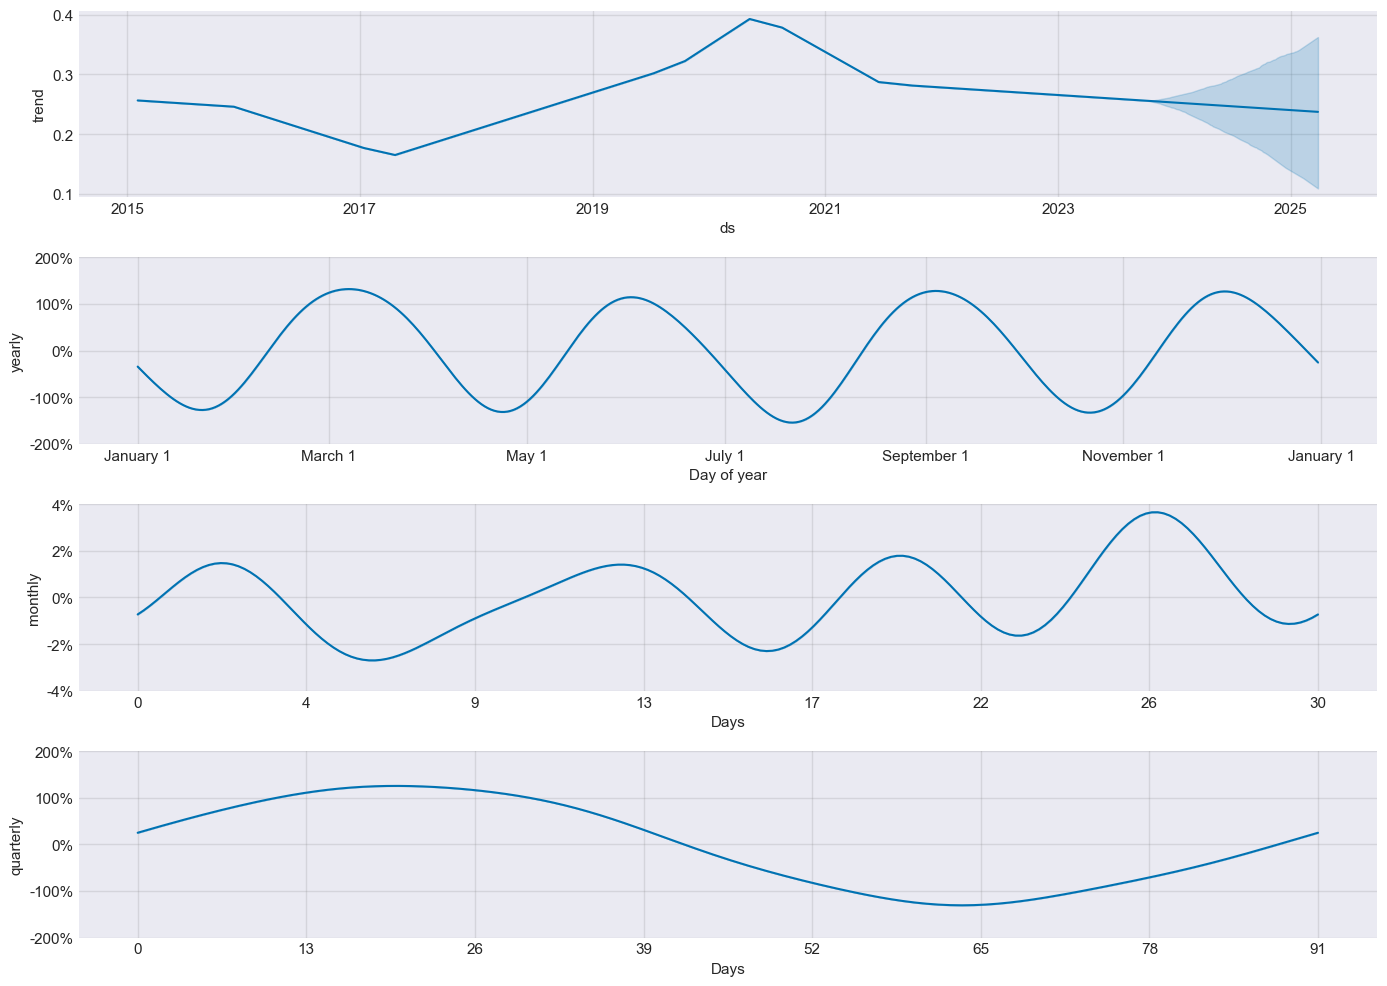


NVDA - Prophet Forecast


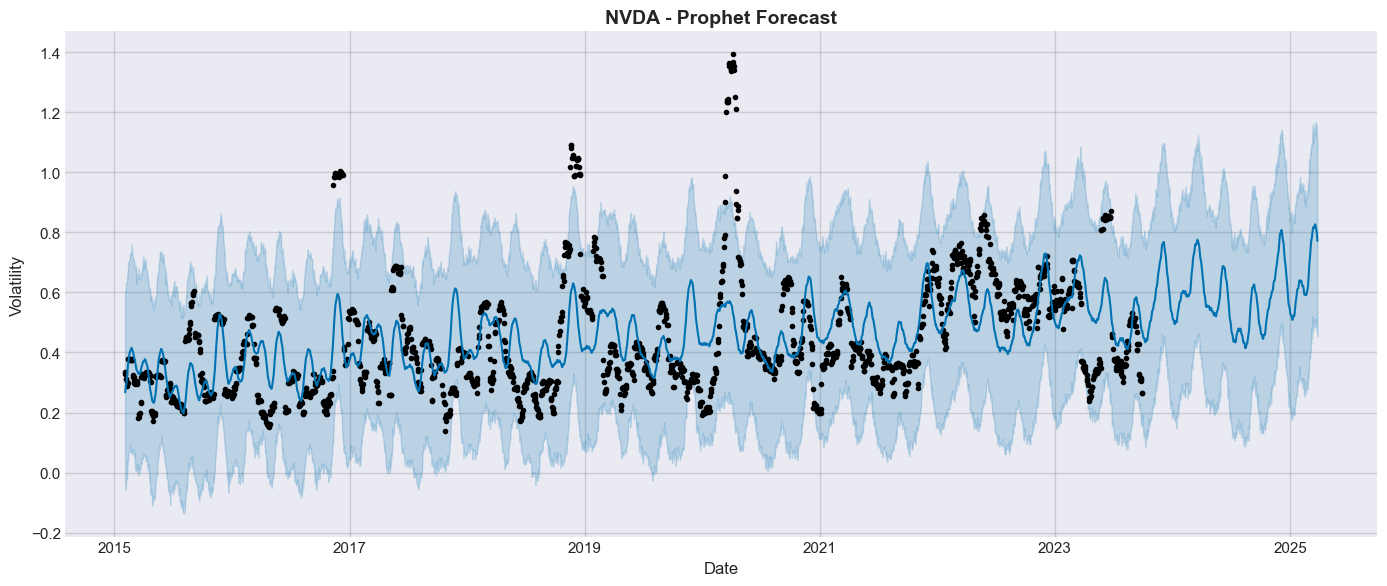


NVDA - Prophet Forecast Components


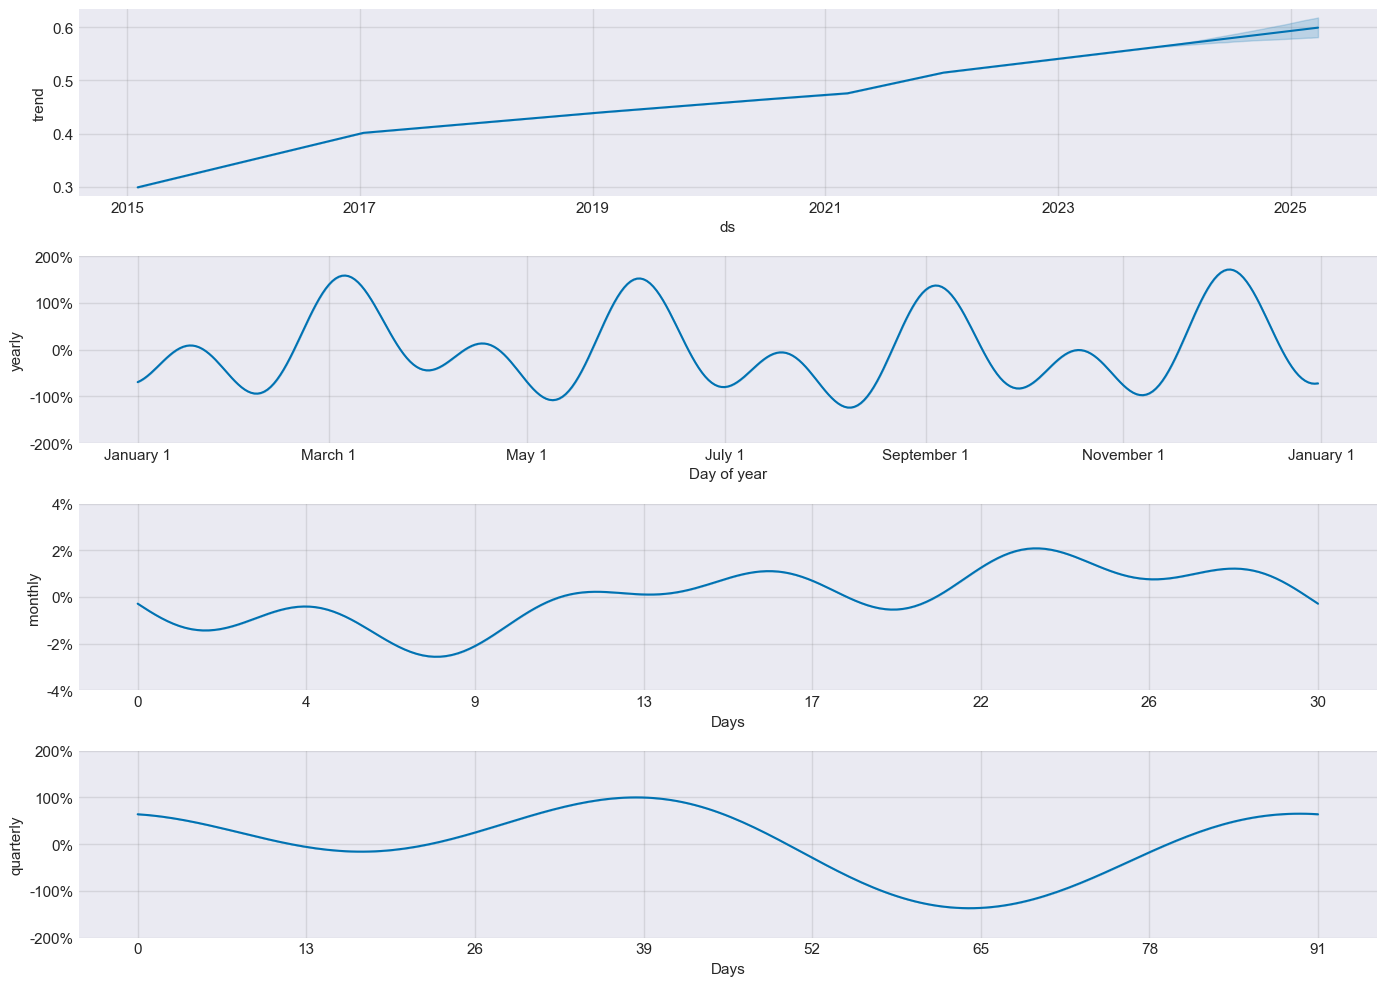


Portfolio - Prophet Forecast


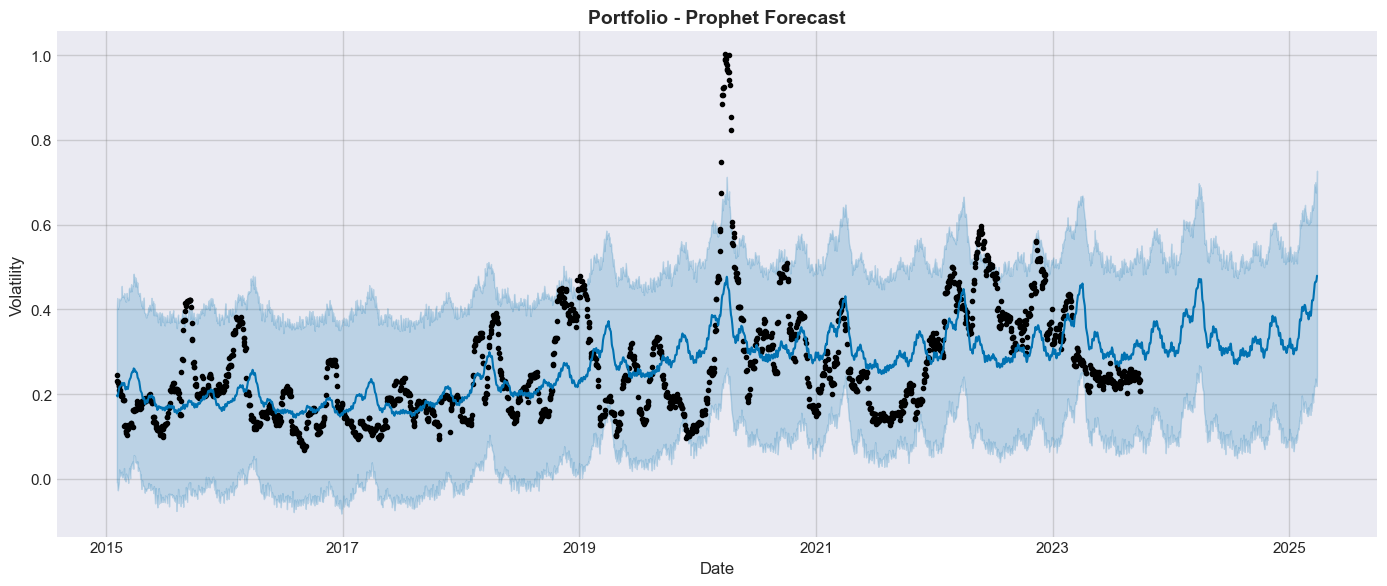


Portfolio - Prophet Forecast Components


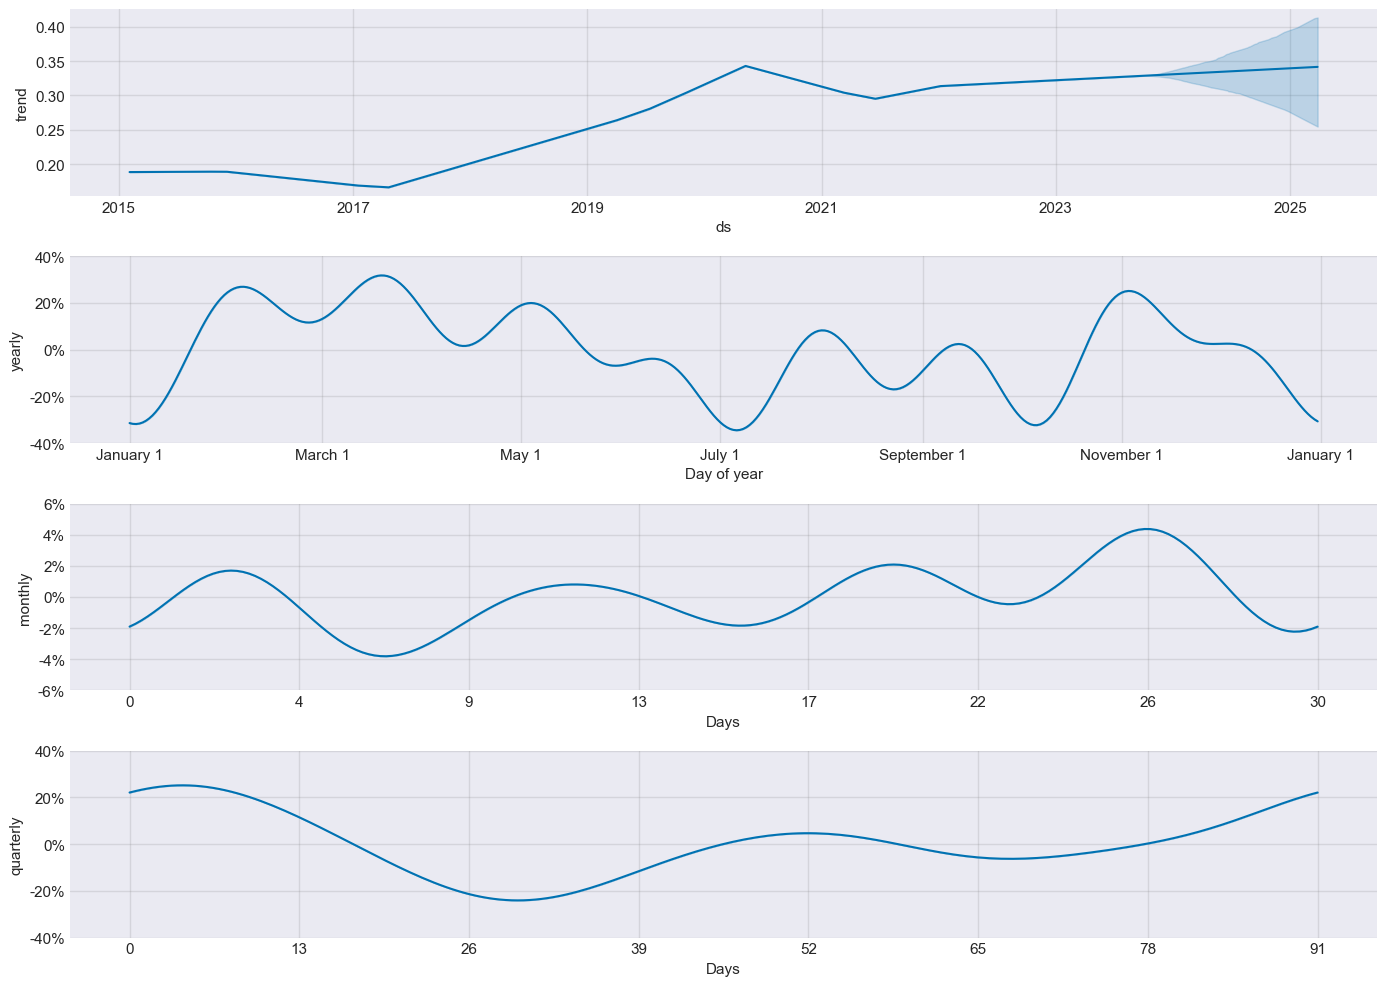

In [117]:
# Plot Prophet forecasts with components
for stock in stocks:
    print(f"\n{stock} - Prophet Forecast")
    fig1 = prophet_models[stock].plot(prophet_full_forecast[stock], figsize=(14, 6))
    plt.title(f'{stock} - Prophet Forecast', fontsize=14, fontweight='bold')
    plt.ylabel('Volatility', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{stock} - Prophet Forecast Components")
    fig2 = prophet_models[stock].plot_components(prophet_full_forecast[stock], figsize=(14, 10))
    plt.tight_layout()
    plt.show()

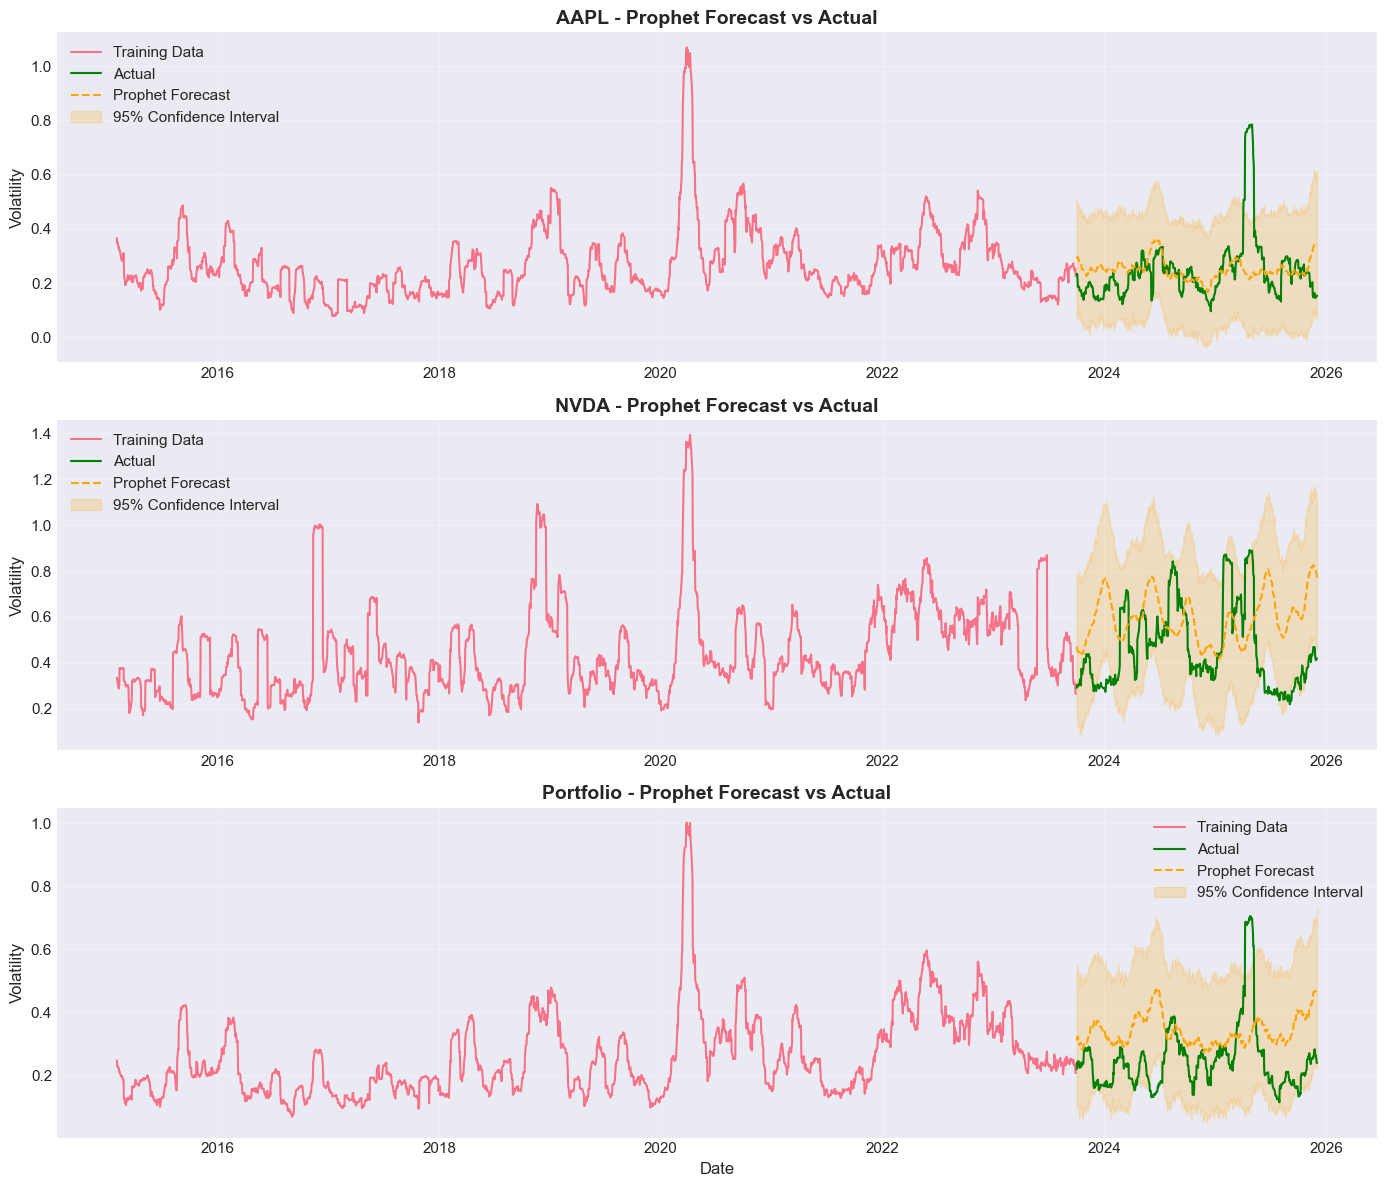

In [118]:
# Detailed comparison plot
fig, axes = plt.subplots(len(stocks), 1, figsize=(14, 12))
if len(stocks) == 1:
    axes = [axes]

for i, stock in enumerate(stocks):
    forecast_df = prophet_full_forecast[stock]
    
    # Plot training data
    axes[i].plot(train_data.index, train_data[stock], label='Training Data', linewidth=1.5)
    
    # Plot test data
    axes[i].plot(test_data.index, test_data[stock], label='Actual', linewidth=1.5, color='green')
    
    # Plot forecast
    test_forecast = forecast_df.iloc[-len(test_data):]
    axes[i].plot(test_data.index, test_forecast['yhat'].values, label='Prophet Forecast', 
                linewidth=1.5, color='orange', linestyle='--')
    
    # Plot confidence interval
    axes[i].fill_between(test_data.index, 
                         test_forecast['yhat_lower'].values, 
                         test_forecast['yhat_upper'].values,
                         alpha=0.2, color='orange', label='95% Confidence Interval')
    
    axes[i].set_title(f'{stock} - Prophet Forecast vs Actual', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility', fontsize=12)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

In [119]:
# Calculate Prophet performance metrics
prophet_metrics = {}
for stock in stocks:
    prophet_metrics[stock] = calculate_metrics(test_data[stock], prophet_forecasts[stock], 
                                               f"{stock} - Prophet")


AAPL - Prophet Performance Metrics:
MAE:  0.073184
MSE:  0.015488
RMSE: 0.124452
MAPE: 30.50%
R²:   -0.1020

NVDA - Prophet Performance Metrics:
MAE:  0.222478
MSE:  0.066573
RMSE: 0.258017
MAPE: 59.34%
R²:   -1.0552

Portfolio - Prophet Performance Metrics:
MAE:  0.126209
MSE:  0.023776
RMSE: 0.154193
MAPE: 61.77%
R²:   -1.0443


## 7. Model Comparison

### 7.1 Performance Metrics

Compare MAE, RMSE, MAPE, and R² across all models for each stock and portfolio.

In [120]:
# Create comprehensive comparison table
comparison_data = []

for stock in stocks:
    # ARIMA
    comparison_data.append({
        'Stock': stock,
        'Model': f'ARIMA{arima_params[stock]}',
        'MAE': arima_metrics[stock]['MAE'],
        'RMSE': arima_metrics[stock]['RMSE'],
        'MAPE': arima_metrics[stock]['MAPE'],
        'R²': arima_metrics[stock]['R2']
    })
    
    # Exponential Smoothing
    comparison_data.append({
        'Stock': stock,
        'Model': es_best_names[stock],
        'MAE': es_metrics[stock]['MAE'],
        'RMSE': es_metrics[stock]['RMSE'],
        'MAPE': es_metrics[stock]['MAPE'],
        'R²': es_metrics[stock]['R2']
    })
    
    # Prophet
    comparison_data.append({
        'Stock': stock,
        'Model': 'Prophet',
        'MAE': prophet_metrics[stock]['MAE'],
        'RMSE': prophet_metrics[stock]['RMSE'],
        'MAPE': prophet_metrics[stock]['MAPE'],
        'R²': prophet_metrics[stock]['R2']
    })

comparison_df = pd.DataFrame(comparison_data)

print("MODEL COMPARISON - PERFORMANCE METRICS")
print(comparison_df.to_string(index=False))

# Find best model for each stock
print("\nBEST MODELS BY METRIC")
for stock in stocks:
    stock_data = comparison_df[comparison_df['Stock'] == stock]
    print(f"\n{stock}:")
    print(f"  Lowest MAE:  {stock_data.loc[stock_data['MAE'].idxmin(), 'Model']} ({stock_data['MAE'].min():.6f})")
    print(f"  Lowest RMSE: {stock_data.loc[stock_data['RMSE'].idxmin(), 'Model']} ({stock_data['RMSE'].min():.6f})")
    print(f"  Lowest MAPE: {stock_data.loc[stock_data['MAPE'].idxmin(), 'Model']} ({stock_data['MAPE'].min():.2f}%)")
    print(f"  Highest R²:  {stock_data.loc[stock_data['R²'].idxmax(), 'Model']} ({stock_data['R²'].max():.4f})")

MODEL COMPARISON - PERFORMANCE METRICS
    Stock          Model      MAE     RMSE      MAPE        R²
     AAPL ARIMA(2, 0, 5) 0.075083 0.118499       NaN  0.000901
     AAPL            SES 0.069372 0.120408       NaN -0.031545
     AAPL        Prophet 0.073184 0.124452 30.502183 -0.102003
     NVDA ARIMA(5, 0, 5) 0.144811 0.180491       NaN -0.005676
     NVDA            SES 0.203239 0.270085       NaN -1.251890
     NVDA        Prophet 0.222478 0.258017 59.337110 -1.055160
Portfolio ARIMA(3, 0, 2) 0.071917 0.108058       NaN -0.003986
Portfolio            SES 0.071608 0.116046       NaN -0.157914
Portfolio        Prophet 0.126209 0.154193 61.767856 -1.044302

BEST MODELS BY METRIC

AAPL:
  Lowest MAE:  SES (0.069372)
  Lowest RMSE: ARIMA(2, 0, 5) (0.118499)
  Lowest MAPE: Prophet (30.50%)
  Highest R²:  ARIMA(2, 0, 5) (0.0009)

NVDA:
  Lowest MAE:  ARIMA(5, 0, 5) (0.144811)
  Lowest RMSE: ARIMA(5, 0, 5) (0.180491)
  Lowest MAPE: Prophet (59.34%)
  Highest R²:  ARIMA(5, 0, 5) (-0.0057

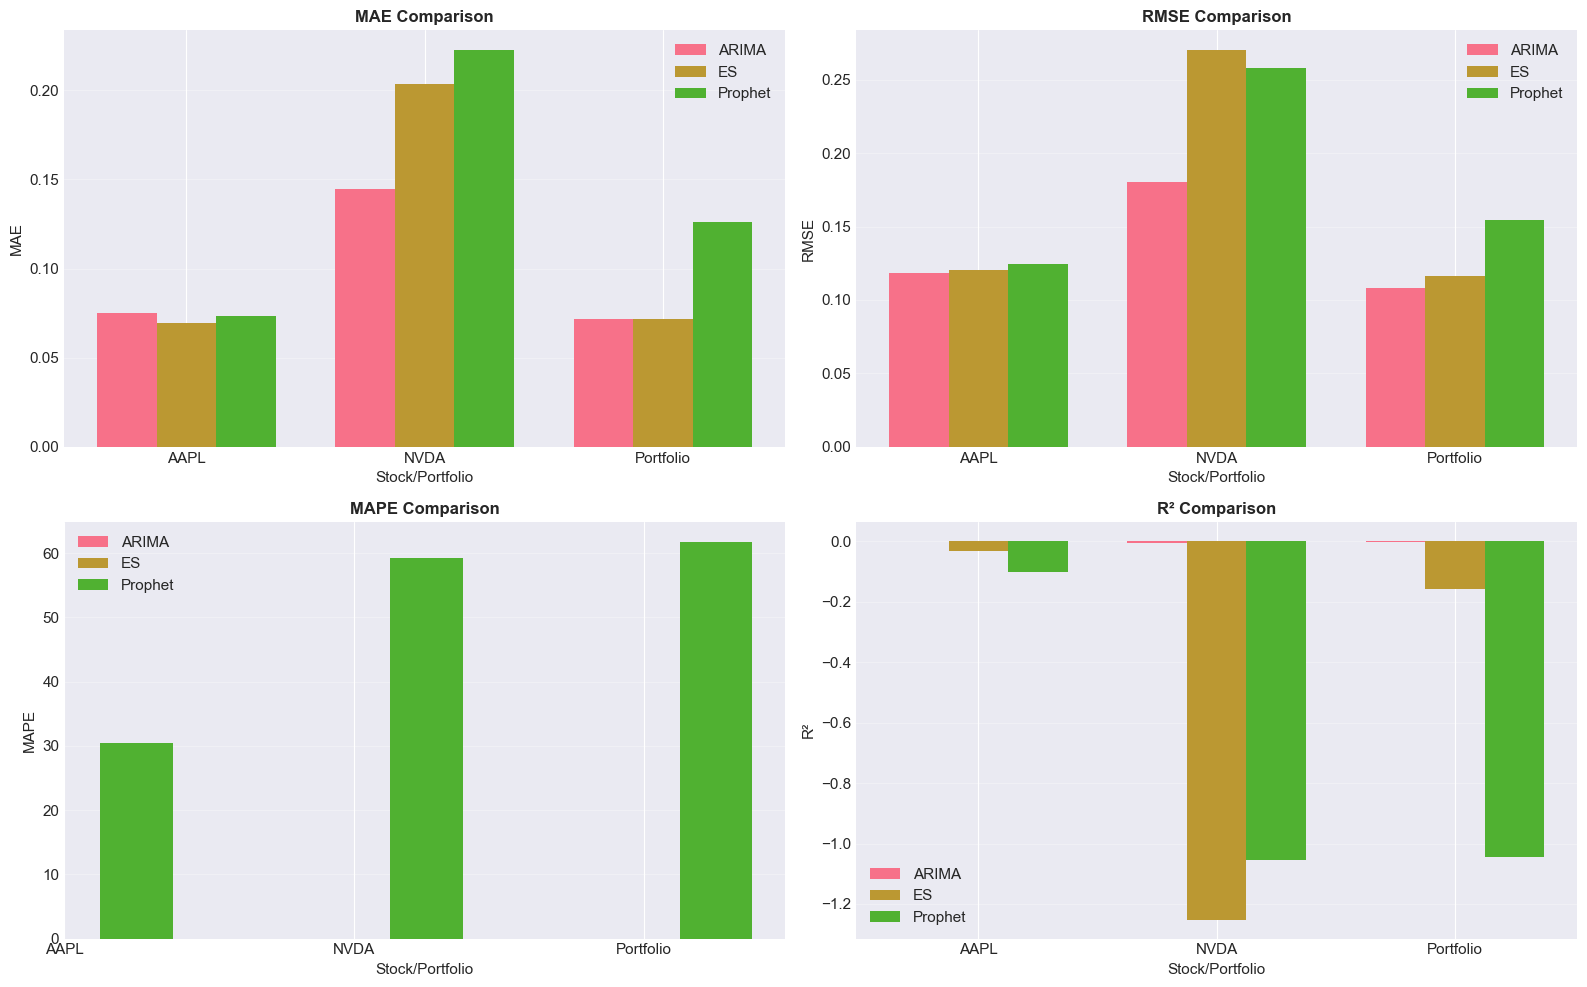

In [121]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics = ['MAE', 'RMSE', 'MAPE', 'R²']
for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    
    # Create grouped bar chart
    stock_positions = np.arange(len(stocks))
    width = 0.25
    
    for i, model_type in enumerate(['ARIMA', 'ES', 'Prophet']):
        values = []
        for stock in stocks:
            stock_data = comparison_df[comparison_df['Stock'] == stock]
            if model_type == 'ARIMA':
                val = stock_data[stock_data['Model'].str.contains('ARIMA')][metric].values[0]
            elif model_type == 'ES':
                val = stock_data[~stock_data['Model'].str.contains('ARIMA|Prophet')][metric].values[0]
            else:
                val = stock_data[stock_data['Model'] == 'Prophet'][metric].values[0]
            values.append(val)
        
        axes[row, col].bar(stock_positions + i*width, values, width, label=model_type)
    
    axes[row, col].set_xlabel('Stock/Portfolio', fontsize=11)
    axes[row, col].set_ylabel(metric, fontsize=11)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].set_xticks(stock_positions + width)
    axes[row, col].set_xticklabels(stocks)
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 7.3 Forecast Comparison

Visual comparison of all three model forecasts against actual values.

### 7.2 Residual Diagnostics

Verify residuals behave like white noise (random fluctuations around zero indicate good model fit).

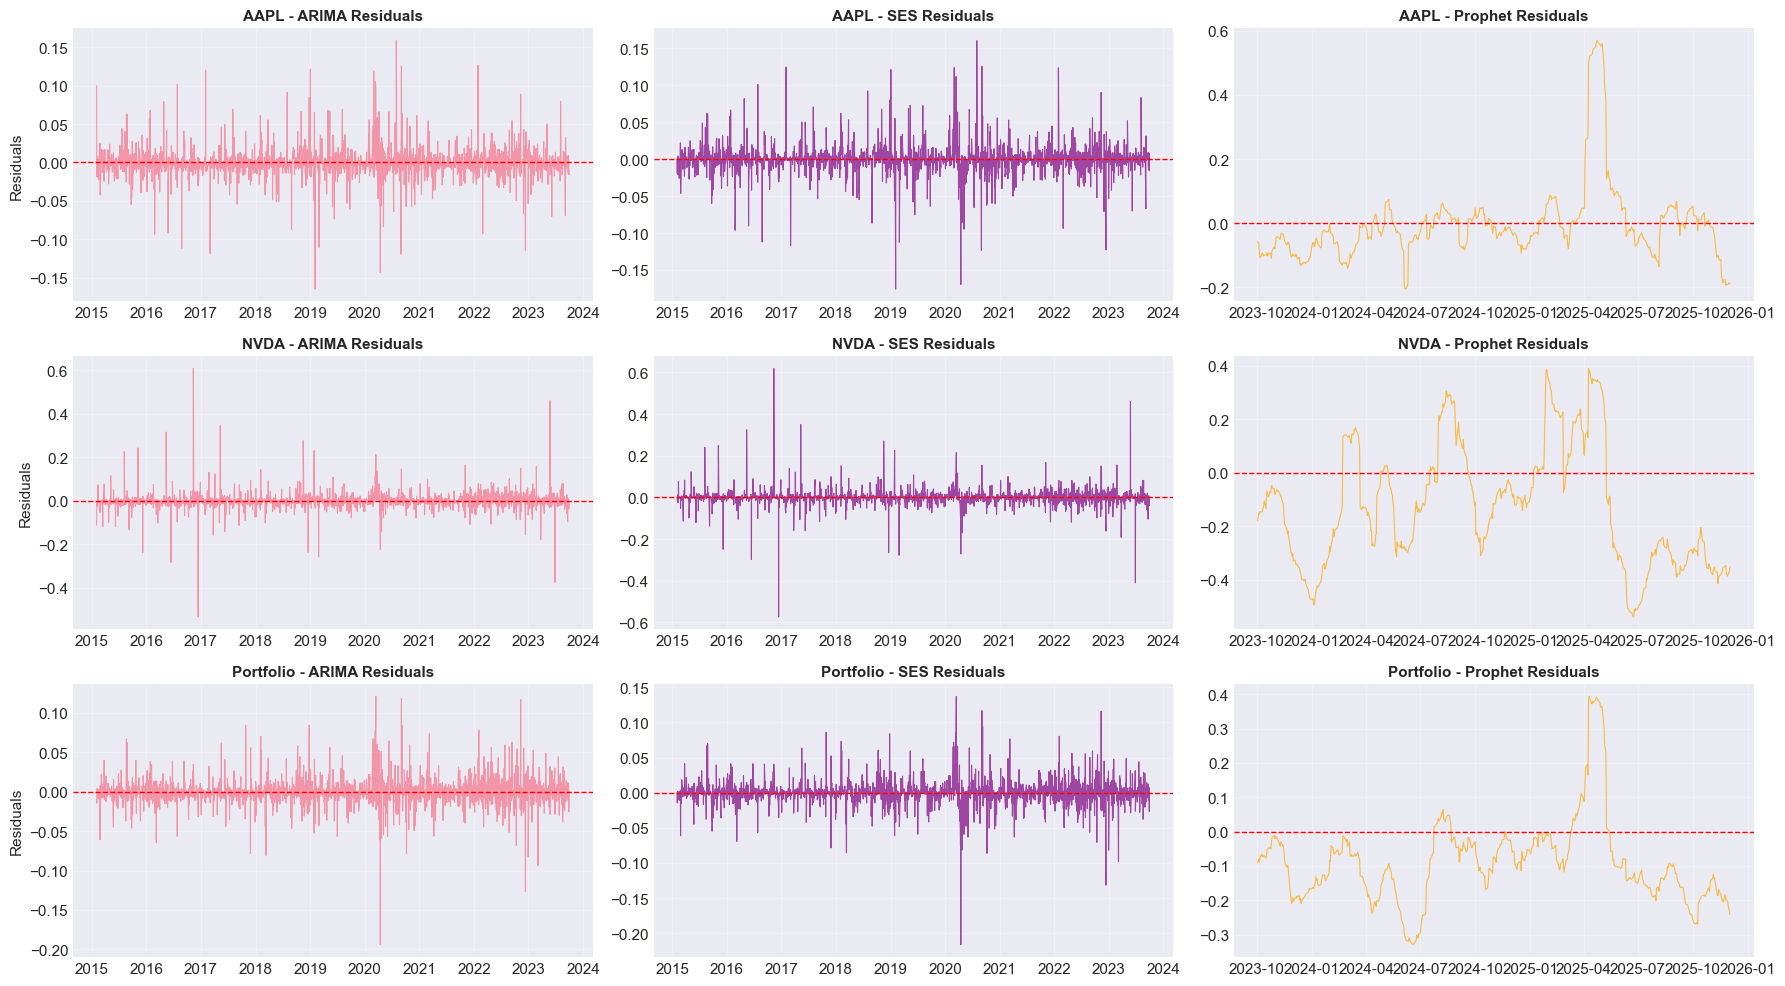

In [122]:
# Consolidated residual check for all models
fig, axes = plt.subplots(len(stocks), 3, figsize=(18, 10))
if len(stocks) == 1:
    axes = axes.reshape(1, -1)

for i, stock in enumerate(stocks):
    # ARIMA residuals
    arima_resid = arima_models[stock].resid
    axes[i, 0].plot(arima_resid, linewidth=0.8, alpha=0.7)
    axes[i, 0].axhline(y=0, color='r', linestyle='--', linewidth=1)
    axes[i, 0].set_title(f'{stock} - ARIMA Residuals', fontsize=11, fontweight='bold')
    axes[i, 0].set_ylabel('Residuals')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Exponential Smoothing residuals
    es_resid = es_best_models[stock].resid
    axes[i, 1].plot(es_resid, linewidth=0.8, alpha=0.7, color='purple')
    axes[i, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)
    axes[i, 1].set_title(f'{stock} - {es_best_names[stock]} Residuals', fontsize=11, fontweight='bold')
    axes[i, 1].grid(True, alpha=0.3)
    
    # Prophet residuals (calculated from forecast errors)
    prophet_resid = test_data[stock].values - prophet_forecasts[stock]
    axes[i, 2].plot(test_data.index, prophet_resid, linewidth=0.8, alpha=0.7, color='orange')
    axes[i, 2].axhline(y=0, color='r', linestyle='--', linewidth=1)
    axes[i, 2].set_title(f'{stock} - Prophet Residuals', fontsize=11, fontweight='bold')
    axes[i, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Residuals show systematic patterns (trends, volatility clusters) rather than random noise, indicating models are not fully capturing underlying volatility dynamics.

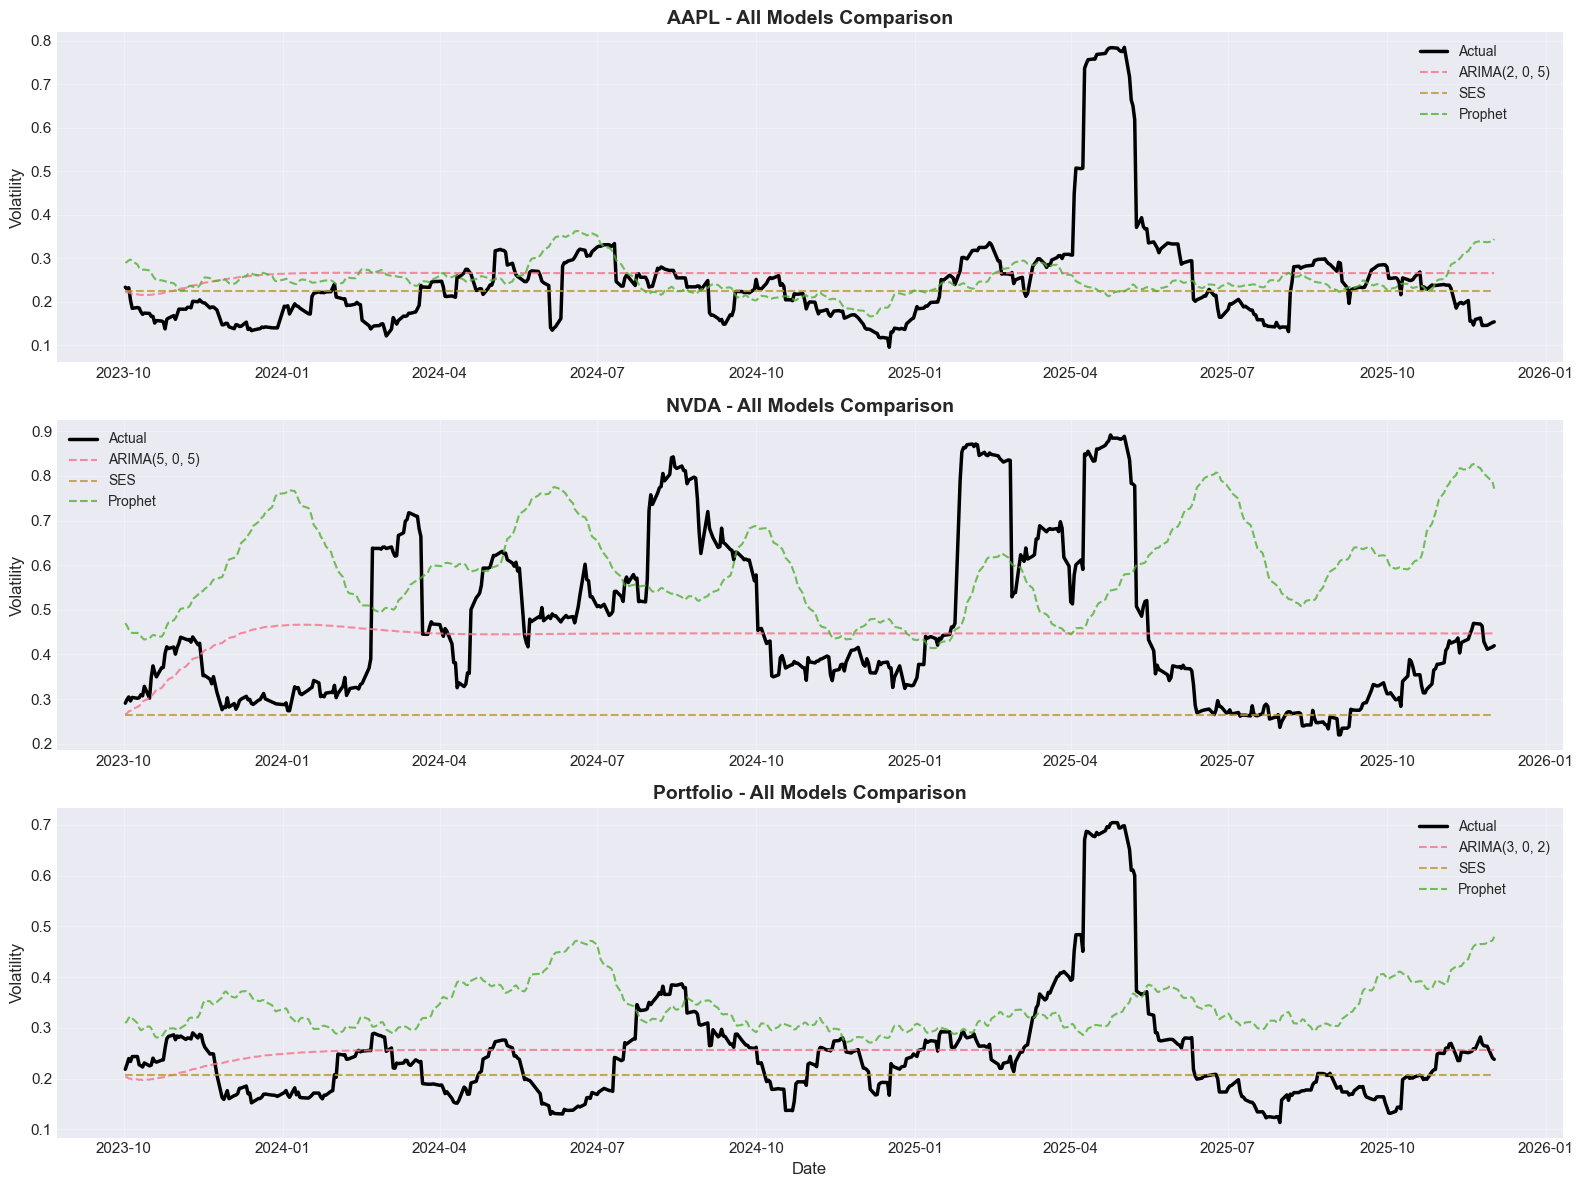

In [123]:
# Plot all forecasts together for comparison
fig, axes = plt.subplots(len(stocks), 1, figsize=(16, 12))
if len(stocks) == 1:
    axes = [axes]

for i, stock in enumerate(stocks):
    # Plot actual test data
    axes[i].plot(test_data.index, test_data[stock], label='Actual', linewidth=2.5, color='black')
    
    # Plot ARIMA forecast
    axes[i].plot(test_data.index, arima_forecasts[stock], 
                label=f'ARIMA{arima_params[stock]}', linewidth=1.5, linestyle='--', alpha=0.8)
    
    # Plot Exponential Smoothing forecast
    axes[i].plot(test_data.index, es_forecasts[stock], 
                label=es_best_names[stock], linewidth=1.5, linestyle='--', alpha=0.8)
    
    # Plot Prophet forecast
    axes[i].plot(test_data.index, prophet_forecasts[stock], 
                label='Prophet', linewidth=1.5, linestyle='--', alpha=0.8)
    
    axes[i].set_title(f'{stock} - All Models Comparison', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility', fontsize=12)
    axes[i].legend(loc='best', fontsize=10)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

### 7.4 Forecast Error Analysis

Examine error patterns over time to identify systematic biases or time-dependent issues.

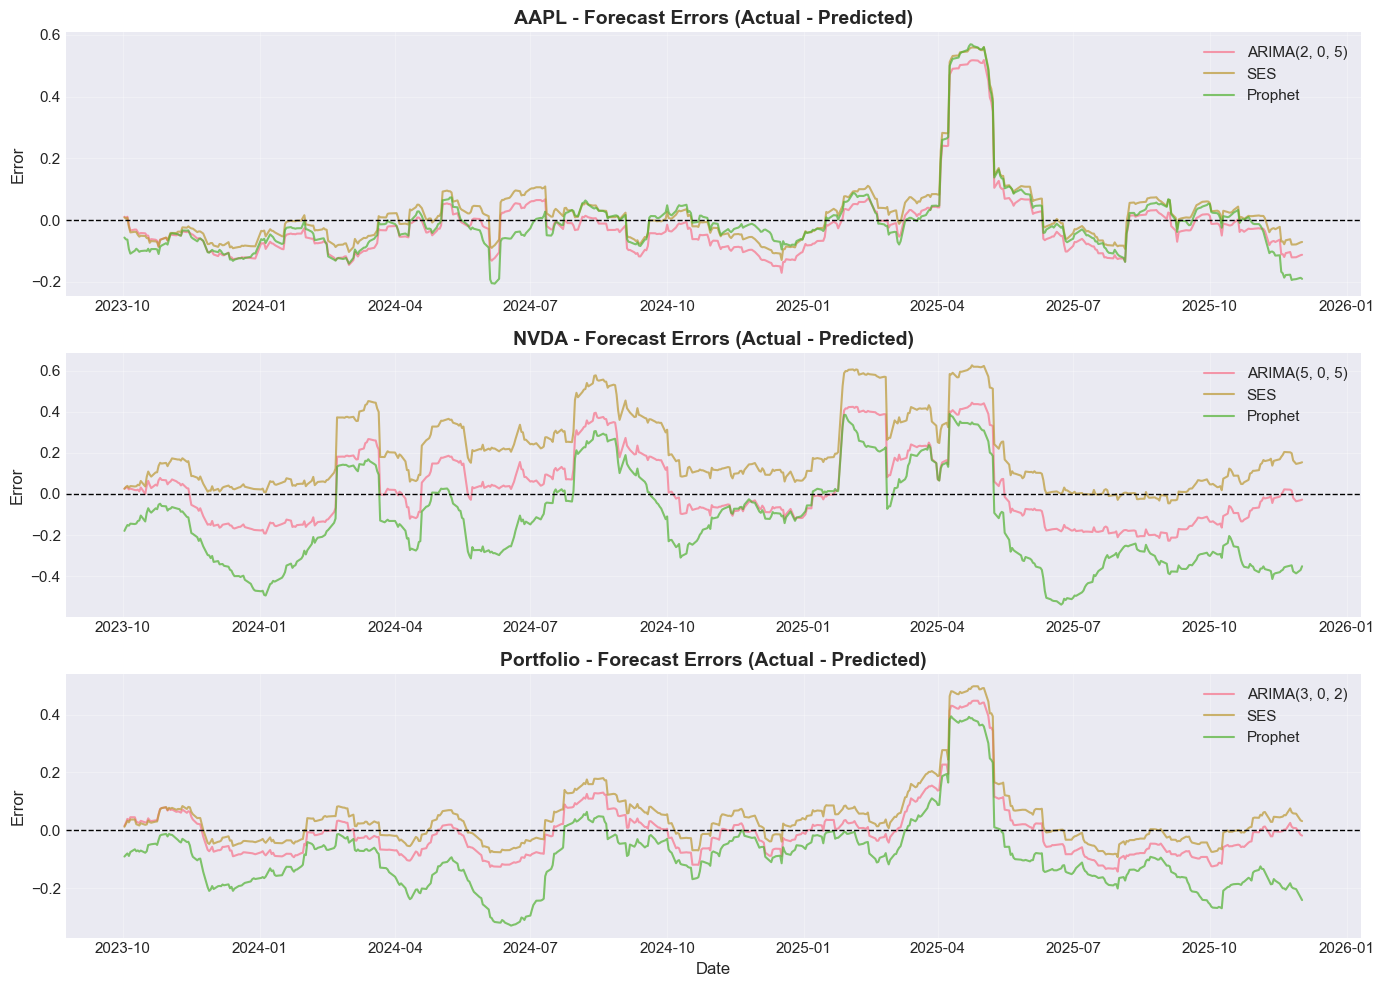

In [124]:
# Calculate and plot forecast errors
fig, axes = plt.subplots(len(stocks), 1, figsize=(14, 10))
if len(stocks) == 1:
    axes = [axes]

for i, stock in enumerate(stocks):
    actual = test_data[stock].values
    
    # Calculate errors
    arima_error = actual - arima_forecasts[stock]
    es_error = actual - es_forecasts[stock]
    prophet_error = actual - prophet_forecasts[stock]
    
    # Plot errors
    axes[i].plot(test_data.index, arima_error, label=f'ARIMA{arima_params[stock]}', linewidth=1.5, alpha=0.7)
    axes[i].plot(test_data.index, es_error, label=es_best_names[stock], linewidth=1.5, alpha=0.7)
    axes[i].plot(test_data.index, prophet_error, label='Prophet', linewidth=1.5, alpha=0.7)
    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    axes[i].set_title(f'{stock} - Forecast Errors (Actual - Predicted)', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Error', fontsize=12)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

## 8. Summary and Conclusions

### Limitations and Next Steps

**Classical Model Limitations:**
- Linear assumptions may not capture volatility clustering (GARCH effects)
- Unable to model regime changes or structural breaks effectively
- Prophet struggles with high-frequency volatility dynamics
- Residual patterns suggest model misspecification

**Next Steps:**
- Compare with advanced ML/DL methods (LSTM, Transformer models) in subsequent notebooks
- Explore GARCH family models for volatility-specific features
- Consider ensemble approaches combining multiple forecasting methods
- Apply these baselines to quantitative finance strategies (risk management, portfolio optimization)

### Portfolio Insights

- Portfolio volatility exhibits different dynamics than individual stocks
- Diversification effects reduce overall volatility magnitude
- Model performance varies between stocks and portfolio
- Equal-weighted MAG7 approach provides baseline for portfolio-level risk assessment

### Key Findings

**Models Evaluated:**
- **ARIMA**: Captures autocorrelations and trends through autoregressive (AR), integrated (I), and moving average (MA) components
- **Exponential Smoothing**: Weights recent observations more heavily, tested SES, Holt, and Holt-Winters variants
- **Prophet**: Decomposes series into trend and multiple seasonality components (yearly, monthly, quarterly)

**Analysis Scope:**
- Individual stocks: AAPL, NVDA
- Equal-weighted MAG7 portfolio (diversified volatility measure)
- Metrics: MAE, RMSE, MAPE, R² for comprehensive performance assessment

**Residual Analysis:**
- Residuals show systematic patterns (trends, volatility clusters) rather than random noise
- Indicates models are not fully capturing underlying volatility dynamics
- May produce biased forecasts with underestimated uncertainty